# [IAPR][iapr]: Project


**Group ID:** 49

**Author 1 (sciper):** Mariane Brodier (250488)  
**Author 2 (sciper):** Lucas Bost (270139)   
**Author 3 (sciper):** Nicolas Delamaide (271789)  

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## Rank classification

First, we import the data of the training set for the ranks and the suites. We also import the MNIST dataset in order to get more data for the ranks (digits). 

If we use the data of the digits and ranks that we got from the training games, the classes are unbalanced : we have about 6000 samples for each digit from MNIST but dozens only for Jack, Queen and King ranks. In order to balance the classes, we will generate around 7000 Jack samples by applying tranformations to the 21 images of J we have. We need around 6000 for training and 1000 for testing to match the class distribution in MNIST. We will do the same procedure for Queen and King ranks.
We also need to map the labels J, Q and K to int, i.e 10, 11, 12 respectively in order for our MLP to use the labels.

We also realized that our classifier doesn't perform well on the digits we extract from cards in the training game, even though they come from the same dataset. This might be due to the fact that we reshape the detected image of the digit to (28x28) which somehow changes the shape too much for our MLP to correctly classify the digit, or some other procedure we use in the detection. To counter this, we decided to add the images of the digits we extracted in the train games to the MNIST data to train our MLP. Like we did for J, Q and K, we generated new samples from the imagesof the digits we had.

Adding the digits from the train games instead of using only digits from MNISt might cause overfitting of our model.

When all of this is done, we merged the new samples to the MNIST dataset. In the end we had about 65 000 training samples with all the classes being balanced, and half our digits comming from MNIST and the other the training games. We then have to classify the data by simply applying an MLP classifier.

For the suites, we will also generate around 7000 Club, Diamond, Heart and Spade samples, merge them and classify them with an MLP classifier.


### Import data

In [1]:
import pickle
import numpy as np
import os

save_folder = "train_set/"

ranks_images = np.load(save_folder+'ranks_im.npy')
with open(save_folder+"ranks_label.txt", "rb") as fp:   # Unpickling
    ranks_label_op = pickle.load(fp)

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_MNIST_folder = os.path.join(os.pardir, 'project/train_set')

train_images_path = os.path.join(data_MNIST_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_MNIST_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_MNIST_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_MNIST_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [4]:
train_images_flattened = train_images.reshape(train_images.shape[0], -1) # Reshape to a 784 - dimensional image
test_images_flattened = test_images.reshape(test_images.shape[0], -1) # Reshape to a 784 - dimensional image

We will first merge the MNIST images and their labels.

In [5]:
train_images_labels = np.concatenate((train_images_flattened, np.expand_dims(train_labels, axis=1)), axis=1)
test_images_labels = np.concatenate((test_images_flattened, np.expand_dims(test_labels, axis=1)), axis=1)

In [6]:
np.random.shuffle(train_images_labels)
np.random.shuffle(test_images_labels)

In [7]:
train_images_labels.shape

(60000, 785)

### Balance classes

The classes are unbalanced, we have about 6000 samples for each digit from MNIST but dozens only for J,Q and K. We also need to map the labels J, Q and K to int, i.e 10, 11, 12 respectively.

In [8]:
map_digit_jqk = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
                 '7': 7, '8': 8, '9': 9, 'J': 10, 'Q': 11, 'K': 12}

for i in range(len(ranks_label_op)):
    ranks_label_op[i] = map_digit_jqk[ranks_label_op[i]]
        
# Convert labels to numpy array
ranks_label_np = np.asarray(ranks_label_op).astype(np.int64)

#### Generate samples for J

In [9]:
ranks_images.shape

(326, 784)

In [10]:
ranks_label_np.shape

(326,)

In [11]:
j_mask = (ranks_label_np == 10)
j_images = ranks_images[j_mask]

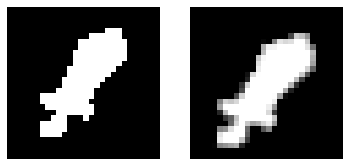

In [12]:
from skimage import transform as tf

# Try some transformation
tform = tf.SimilarityTransform(scale=0.95, rotation= -np.deg2rad(3))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(j_images[3,:].reshape(image_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(j_images[3,:].reshape(image_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

We will generate around 7000 J samples by applying tranformations to the 21 images of J we have. We need around 6000 for training and 1000 for testing to match the class distribution in MNIST.

In [13]:
from random import triangular, uniform

def gen_samples(images, image_label, scale_low=1.15, scale_high=1.25, trans_=(-2.2,-3),
                rot=np.deg2rad(2), num_samples=334):

    gen = []

    for num in range(images.shape[0]):

        im = images[num, :]

        gen.append(im)

        # Generate num_samples samples for each image
        for i in range(num_samples):
           
            tform = tf.SimilarityTransform(scale=uniform(scale_low, scale_high), translation=trans_,
                                           rotation=uniform(-rot, rot))

            gen.append(tf.warp(im.reshape(image_shape), tform).flatten())

    # Combine images + labels in one array
    gen = np.asarray(gen)
    gen_array = np.empty((gen.shape[0], gen.shape[1]+1))
    gen_array[:,:-1] = gen
    gen_array[:, -1] = np.ones((gen.shape[0],)) * image_label

    return gen_array

In [14]:
j_gen = gen_samples(j_images, 10)

In [15]:
j_gen.shape

(7705, 785)

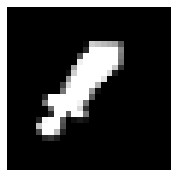

In [16]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(j_gen[3630,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Generate samples for Q

In [17]:
q_mask = (ranks_label_np == 11)
q_images = ranks_images[q_mask]

In [18]:
q_images.shape

(22, 784)

In [19]:
q_gen = gen_samples(q_images, 11)

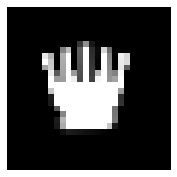

In [20]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(q_gen[6000,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Generate samples for K

In [21]:
k_mask = (ranks_label_np == 12)
k_images = ranks_images[k_mask]

In [22]:
k_images.shape

(26, 784)

In [23]:
k_gen = gen_samples(k_images, 12)

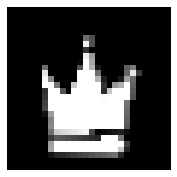

In [24]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(k_gen[2679,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Merge generated data

In [25]:
merged_gen = np.append(j_gen, q_gen, axis=0)
merged_gen = np.append(merged_gen, k_gen, axis=0)
np.random.shuffle(merged_gen)

In [26]:
merged_gen.shape

(23785, 785)

#### Incorporate extracted digits to MNIST

We realized that even though the digits on the cards come from MNIST, when they are detected by our processing algorithm our classifier doesn't recognize them as such. We decided to add the digits from the train games we were given to the dataset, en drop some of the MNIST digits. We create about 4000 samples for each digit class (0-9).

In [27]:
mask_digit = ((ranks_label_np != 10) & (ranks_label_np != 11) & (ranks_label_np != 12))
digit_images = ranks_images[mask_digit]

In [28]:
digit_images.shape

(255, 784)

In [29]:
digit_labels = ranks_label_np[mask_digit]
set_digit_labels = np.unique(digit_labels).tolist()

gen_digits = np.empty((0, digit_images.shape[1]+1))

for idx in set_digit_labels:
    
    samples = gen_samples(digit_images[(digit_labels==idx)], idx, scale_low=1.05, scale_high=1.3, trans_=(-2.2,-3),
                rot=np.deg2rad(4), num_samples=160)
    gen_digits = np.append(gen_digits, samples, axis=0)


np.random.shuffle(gen_digits)
gen_digits.shape

(41055, 785)

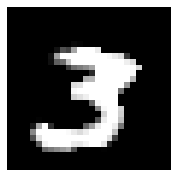

In [30]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(gen_digits[13941,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

Now we merge our generated digits with part of MNIST. We will pick 25 000 samples from our generated digits and 20 000 samples from MNIST for our train set, and we will pick 5 000 from our samples and MNIST for our test set.

In [31]:
digits_mnist_train = np.append(gen_digits[:25000], train_images_labels[:20000], axis=0)
digits_mnist_test = np.append(gen_digits[30000:35000], train_images_labels[30000:35000], axis=0)

print(digits_mnist_train.shape, digits_mnist_test.shape)

(45000, 785) (10000, 785)


Now we merge it to the generated data for JQK. We add 3000 generated samples (approx 1000 for each class JQK) to the test data and the rest to the train data.

In [32]:
# Test data
test_merged = np.append(merged_gen[:3000], digits_mnist_test, axis=0)
np.random.shuffle(test_merged)

# Train data
train_merged = np.append(merged_gen[3000:], digits_mnist_train, axis=0)
np.random.shuffle(train_merged)

In [33]:
print(test_merged.shape, train_merged.shape)

(13000, 785) (65785, 785)


We save the train and test data for later use.

In [34]:
np.save(save_folder+'test_ranks.npy', test_merged)
np.save(save_folder+'train_ranks.npy', train_merged)

### Classification

We need to split the images and the labels again.

In [35]:
train_im = train_merged[:,:-1]
train_labels = train_merged[:,-1].astype(np.int64)

test_im = test_merged[:,:-1]
test_labels = test_merged[:,-1].astype(np.int64)

We train a simple MLP to perform classification

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # to scale the values of the pixels
scaler.fit(train_im)  

train_images_scaled = scaler.transform(train_im)  # Scale train_images
test_images_scaled = scaler.transform(test_im) # Scale test_images

hidden_units = 100

clf = MLPClassifier(hidden_layer_sizes = (hidden_units,), random_state=42, max_iter=150).fit(train_images_scaled, train_labels)

clf.score(test_images_scaled, test_labels)

/Users/Nicolas/anaconda3/envs/iapr/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9107692307692308

(-0.5, 27.5, 27.5, -0.5)

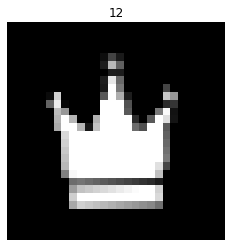

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

idx=1298
ax.imshow(test_im[idx].reshape((28, 28)), cmap='gray')
ax.set_title(str(clf.predict(test_images_scaled[idx].reshape(1, -1))[0]))
ax.axis('off')

---
### Suite classification
#### Import data

In [38]:
# Open suite files
suites_images = np.load(save_folder+'suites_im.npy')
with open(save_folder+"suites_label.txt", "rb") as fp2:   # Unpickling
    suites_label_op = pickle.load(fp2)

In [39]:
map_hcds = {'H': 0, 'C': 1, 'D': 2, 'S': 3}

for i in range(len(suites_label_op)):
    suites_label_op[i] = map_hcds[suites_label_op[i]]
        
# Convert labels to numpy array
suites_label_op = np.asarray(suites_label_op).astype(np.int64)

#### Generate samples

##### For H

In [40]:
h_mask = (suites_label_op == 0)
h_images = suites_images[h_mask]

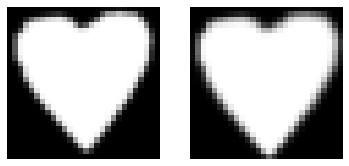

In [41]:
from skimage.transform import resize

suite_shape = (28,28)

# Try some transformation
tform = tf.SimilarityTransform(scale=0.97, rotation= -np.deg2rad(1))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(h_images[30,:].reshape(suite_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(h_images[30,:].reshape(suite_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [42]:
h_images.shape

(87, 784)

As for the ranks, we will generate around 7000 samples, 6000 for training and 1000 for testing

In [43]:
def gen_samples_suites(images, image_label, scale_low=0.94, scale_high=1,
                rot=np.deg2rad(3), num_samples=168):

    gen = []

    for num in range(images.shape[0]):

        im = images[num, :]
        
        gen.append(im.flatten())

        # Generate num_samples samples for each image
        for i in range(num_samples):
           
            tform = tf.SimilarityTransform(scale=uniform(scale_low, scale_high), rotation=uniform(-rot, rot))

            gen.append(tf.warp(im.reshape(suite_shape), tform).flatten())

    # Combine images + labels in one array
    gen = np.asarray(gen)
    gen_array = np.empty((gen.shape[0], gen.shape[1]+1))
    gen_array[:,:-1] = gen
    gen_array[:, -1] = np.ones((gen.shape[0],)) * image_label

    return gen_array

In [44]:
h_gen = gen_samples_suites(h_images, 0, num_samples=81)

In [45]:
h_gen.shape

(7134, 785)

##### For C

In [46]:
c_mask = (suites_label_op == 1)
c_images = suites_images[c_mask]

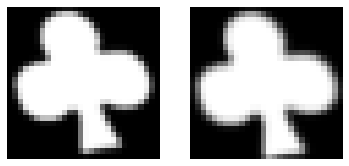

In [47]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.97, rotation= -np.deg2rad(1))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(c_images[30,:].reshape(suite_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(c_images[30,:].reshape(suite_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [48]:
c_images.shape

(79, 784)

In [49]:
c_gen = gen_samples_suites(c_images, 1, num_samples=90)

In [50]:
c_gen.shape

(7189, 785)

##### For D

In [51]:
d_mask = (suites_label_op == 2)
d_images = suites_images[d_mask]

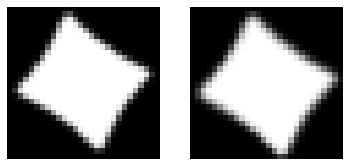

In [52]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.97, rotation= -np.deg2rad(1))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(d_images[30,:].reshape(suite_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(d_images[30,:].reshape(suite_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [53]:
d_images.shape

(78, 784)

In [54]:
d_gen = gen_samples_suites(d_images, 2, num_samples=90)

In [55]:
d_gen.shape

(7098, 785)

##### For S

In [56]:
s_mask = (suites_label_op == 3)
s_images = suites_images[s_mask]

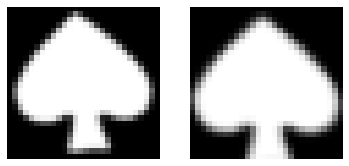

In [57]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.94, rotation= -np.deg2rad(3))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(s_images[30,:].reshape(suite_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(s_images[30,:].reshape(suite_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [58]:
s_images.shape

(83, 784)

In [59]:
s_gen = gen_samples_suites(s_images, 3, num_samples=85)

In [60]:
s_gen.shape

(7138, 785)

#### Merge generated data

In [61]:
merged_gen = np.append(h_gen, c_gen, axis=0)
merged_gen = np.append(merged_gen, d_gen, axis=0)
merged_gen = np.append(merged_gen, s_gen, axis=0)
np.random.shuffle(merged_gen)

In [62]:
merged_gen.shape

(28559, 785)

As for the ranks we take about 4000 samples for the test set (1000 for each class) and the rest for the training set.

In [63]:
test_merged = merged_gen[:4000]
train_merged = merged_gen[4000:]

In [64]:
np.save(save_folder+'test_suites.npy', test_merged)
np.save(save_folder+'train_suites.npy', train_merged)

### Classification

We need to split the images and the labels.

In [65]:
train_im = train_merged[:,:-1]
train_labels = train_merged[:,-1].astype(np.int64)

test_im = test_merged[:,:-1]
test_labels = test_merged[:,-1].astype(np.int64)

We train a simple MLP to perform classification

In [66]:
scaler = StandardScaler() # to scale the values of the pixels
scaler.fit(train_im)  

train_images_scaled = scaler.transform(train_im)  # Scale train_images
test_images_scaled = scaler.transform(test_im) # Scale test_images

hidden_units = 100

clf = MLPClassifier(hidden_layer_sizes = (hidden_units,), random_state=42).fit(train_images_scaled, train_labels)

clf.score(test_images_scaled, test_labels)

1.0

There is likely overfitting.